# load packages

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import warnings
from muon import prot as pt
from model.train import train_SMART
from model.utils import fix_seed


warnings.filterwarnings('ignore')
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/home/ws6tg/anaconda3/envs/EnvR43/lib/R/'

# load data

In [2]:
from muon import prot as pt
from model.utils import pca

# read data
file_folds = ['./datasets/multi_section_Stereo/Mouse_Thymus2/','./datasets/multi_section_Stereo/Mouse_Thymus3/','./datasets/multi_section_Stereo/Mouse_Thymus4/']  #please replace 'file_fold' with the download path
name = ["Replicate-1", "Replicate-2", "Replicate-3"]
rna_adatas = {}
adt_adatas = {}
for file_fold, name in zip(file_folds, name):
    adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
    adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

    adata_omics1.var_names_make_unique()
    adata_omics2.var_names_make_unique()

    from model.utils import Cal_Spatial_Net

    Cal_Spatial_Net(adata_omics1, model="Radius", radius=100)
    Cal_Spatial_Net(adata_omics2, model="Radius", radius=100)
    
    rna_adatas[name] = adata_omics1.copy()
    adt_adatas[name] = adata_omics2.copy()

The graph contains 16566 edges, 4253 cells.
3.8951 neighbors per cell on average.
The graph contains 16566 edges, 4253 cells.
3.8951 neighbors per cell on average.
The graph contains 18144 edges, 4646 cells.
3.9053 neighbors per cell on average.
The graph contains 18144 edges, 4646 cells.
3.9053 neighbors per cell on average.
The graph contains 16474 edges, 4228 cells.
3.8964 neighbors per cell on average.
The graph contains 16474 edges, 4228 cells.
3.8964 neighbors per cell on average.


# sections intergration and spatial neighbour graph construction

In [3]:
adata_RNA=sc.concat(rna_adatas, label="batch",index_unique="_")
adata_ADT=sc.concat(adt_adatas, label="batch",index_unique="_")

import scipy
import numpy as np

adjs=[i.uns["adj"].todense() for i in rna_adatas.values()]
adj_concat = np.asarray(adjs[0])
for batch_id in range(1,len(rna_adatas.values())):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adjs[batch_id]))

adata_RNA.uns['adj'] = adj_concat
adata_RNA.uns['edgeList'] = np.nonzero(adj_concat)

adjs=[i.uns["adj"].todense() for i in adt_adatas.values()]
adj_concat = np.asarray(adjs[0])
for batch_id in range(1,len(rna_adatas.values())):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adjs[batch_id]))

adata_ADT.uns['adj'] = adj_concat
adata_ADT.uns['edgeList'] = np.nonzero(adj_concat)

# data pre-processing and batch effect removal

In [4]:
from model.utils import pca

# RNA
sc.pp.filter_genes(adata_RNA, min_cells=10)
sc.pp.highly_variable_genes(adata_RNA, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)

adata_RNA.raw=adata_RNA
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable']]
adata_RNA.obsm['X_pca'] = pca(adata_RNA, n_comps=30)
sc.external.pp.harmony_integrate(adata_RNA,"batch")
# Protein

pt.pp.clr(adata_ADT)
sc.pp.scale(adata_ADT)
adata_ADT.obsm['X_pca'] = pca(adata_ADT, n_comps=18)
sc.external.pp.harmony_integrate(adata_ADT,"batch")

2025-02-02 03:47:43,466 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-02 03:47:44,772 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-02 03:47:44,813 - harmonypy - INFO - Iteration 1 of 10
2025-02-02 03:47:47,233 - harmonypy - INFO - Iteration 2 of 10
2025-02-02 03:47:50,429 - harmonypy - INFO - Iteration 3 of 10
2025-02-02 03:47:52,725 - harmonypy - INFO - Iteration 4 of 10
2025-02-02 03:47:54,985 - harmonypy - INFO - Iteration 5 of 10
2025-02-02 03:47:57,250 - harmonypy - INFO - Iteration 6 of 10
2025-02-02 03:47:58,195 - harmonypy - INFO - Converged after 6 iterations
2025-02-02 03:47:58,224 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-02 03:47:59,084 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-02 03:47:59,125 - harmonypy - INFO - Iteration 1 of 10
2025-02-02 03:48:01,265 - harmonypy - INFO - Iteration 2 of 10
2025-02-02 03:48:03,475 - harmonypy - INFO - Iteration 3 of 

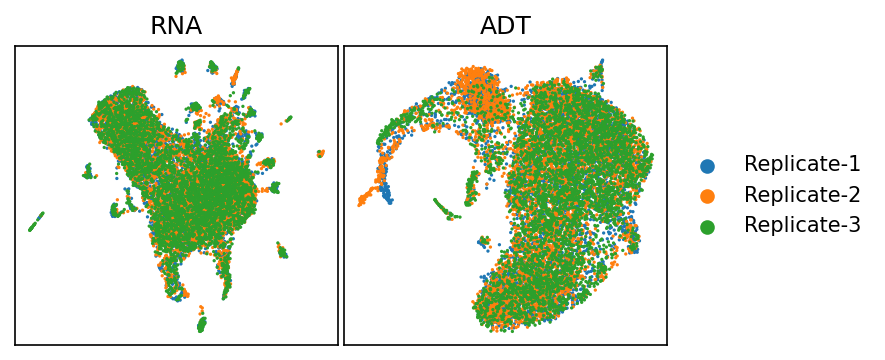

In [5]:
from matplotlib import pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(6, 2.5),dpi=150)
sc.pp.neighbors(adata_RNA, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[0], title='RNA', s=10 ,show=False)
ax_list[0].get_legend().remove()
sc.pp.neighbors(adata_ADT, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_ADT)
sc.pl.umap(adata_ADT, color='batch', ax=ax_list[1], title='ADT', s=10, show=False)
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.tight_layout(w_pad=0.3)
plt.show()

# MNN triplet samples calculation

In [6]:
from model.utils import Mutual_Nearest_Neighbors

anchors1, positives1, negatives1 = Mutual_Nearest_Neighbors(adata_RNA, key="X_pca_harmony", n_nearest_neighbors=3,
                                                            farthest_ratio=0.6)
anchors2, positives2, negatives2 = Mutual_Nearest_Neighbors(adata_ADT, key="X_pca_harmony", n_nearest_neighbors=3,
                                                            farthest_ratio=0.6)

distances calculation completed!
The data use feature 'X_pca_harmony' contains 8102 mnn_anchors
distances calculation completed!
The data use feature 'X_pca_harmony' contains 16700 mnn_anchors


# model training

In [7]:
adata_RNA.obsm["SMART"] = train_SMART(adata_list=[adata_RNA, adata_ADT],
                                       triplet_samples_list=[(anchors1, positives1, negatives1),
                                                             (anchors2, positives2, negatives2)],
                                       feature_key="X_pca_harmony",
                                       edge_key="edgeList",
                                       weights=[1, 1, 1, 1],
                                       emb_dim=64,
                                       n_epochs=150)


100%|█████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 26.69it/s]


# clustering

In [8]:
from model.utils import clustering
from sklearn.metrics import adjusted_rand_score

tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_RNA, key='SMART', add_key='SMART', n_clusters=6, method=tool, use_pca=True)


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


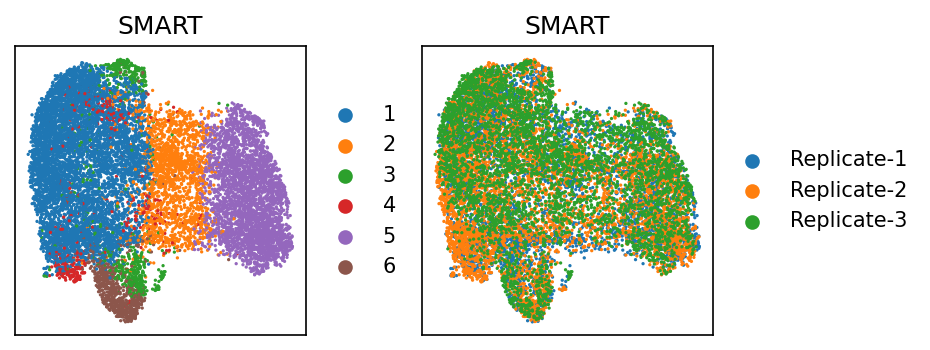

In [9]:
import matplotlib.pyplot as plt
# adata_omics1.obsm['spatial'][:,1] = -1*adata_omics1.obsm['spatial'][:,1]

fig, ax_list = plt.subplots(1, 2, figsize=(6, 2.5),dpi=150)
plt.subplots_adjust(hspace=0.05, wspace=0.4)
sc.pp.neighbors(adata_RNA, use_rep='SMART', n_neighbors=30)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[1], title='SMART', s=10, show=False)
sc.pl.umap(adata_RNA, color='SMART', ax=ax_list[0], title='SMART', s=10, show=False)

ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.show()

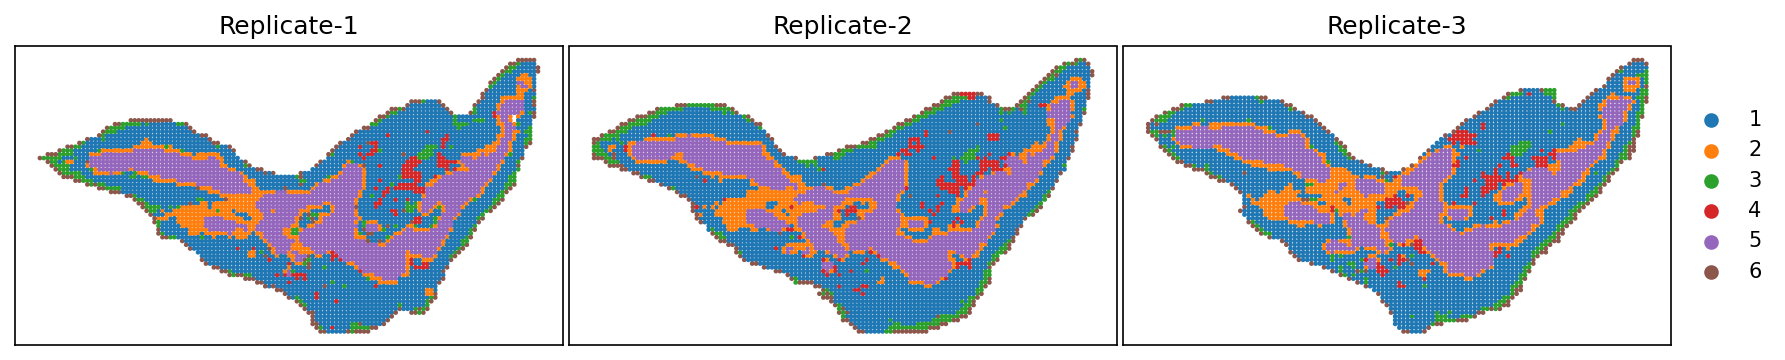

In [10]:
fig, ax_list = plt.subplots(1, 3, figsize=(12, 2.5),dpi=150)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="Replicate-1"].copy(), basis='spatial', color='SMART', ax=ax_list[0], title='Replicate-1', s=20, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="Replicate-2"].copy(), basis='spatial', color='SMART', ax=ax_list[1], title='Replicate-2', s=20, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="Replicate-3"].copy(), basis='spatial', color='SMART', ax=ax_list[2], title='Replicate-3', s=20, show=False)

ax_list[2].set_xlabel("")
ax_list[2].set_ylabel("")
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")

ax_list[0].get_legend().remove()
ax_list[1].get_legend().remove()
plt.tight_layout(w_pad=0.3)
plt.show()

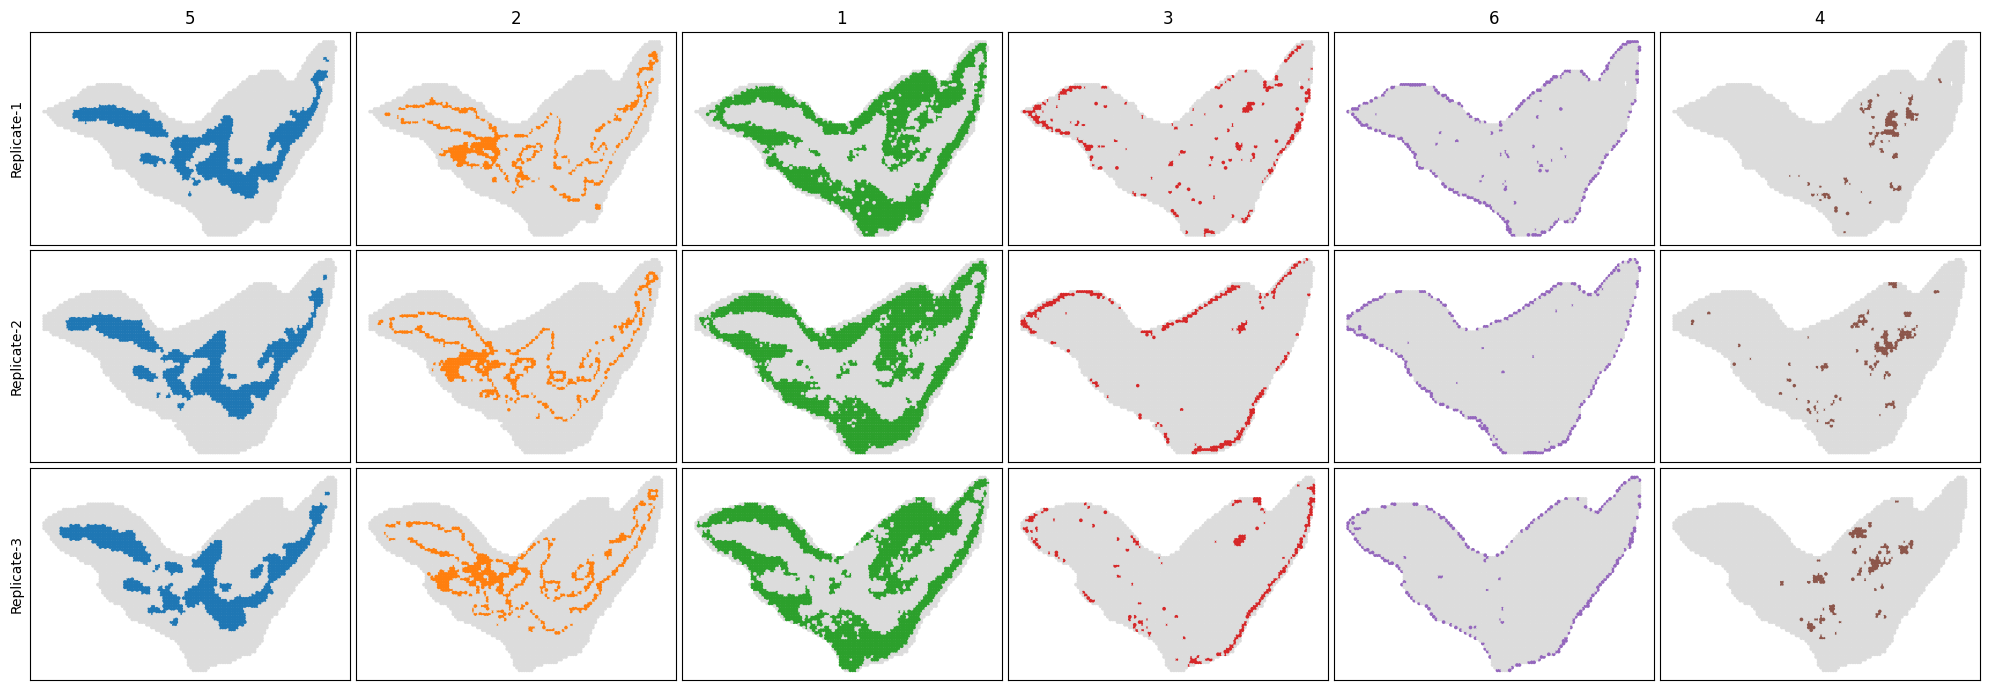

In [11]:
colors = ['#1f77b4',  '#ff7f0e',  '#2ca02c',   '#d62728',  '#9467bd',   '#8c564b',  ]
colordict=dict(zip(adata_RNA.obs["SMART"].unique(),colors))

fig, ax_list = plt.subplots(3, 6, figsize=(20, 7))
for f,b in enumerate(["Replicate-1","Replicate-2","Replicate-3"]):
    for j,k in enumerate(adata_RNA.obs["SMART"].unique()):
        sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]==b].copy(), basis='spatial', color='SMART', palette={i:colordict[i] if i==k else "#DCDCDC" for i in adata_RNA.obs["SMART"].unique()},ax=ax_list[f][j],title=str(k),show=False)
        if f>0:
            ax_list[f][j].set_title("")
        ax_list[f][j].set_xlabel("")
        ax_list[f][j].set_ylabel("")
        ax_list[f][j].get_legend().remove()
    ax_list[f][0].set_ylabel(b)
plt.tight_layout(w_pad=0.4,h_pad=0.4)
plt.show()